In [21]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from scipy.stats import ttest_rel
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import  plot_tree

sys.path.append(os.path.abspath('..'))
from processamento import df, categorical_cols, numeric_cols
from models_training import (
    train_linear_regression,
    train_regression_tree,
    train_svm,
    train_mlp
)

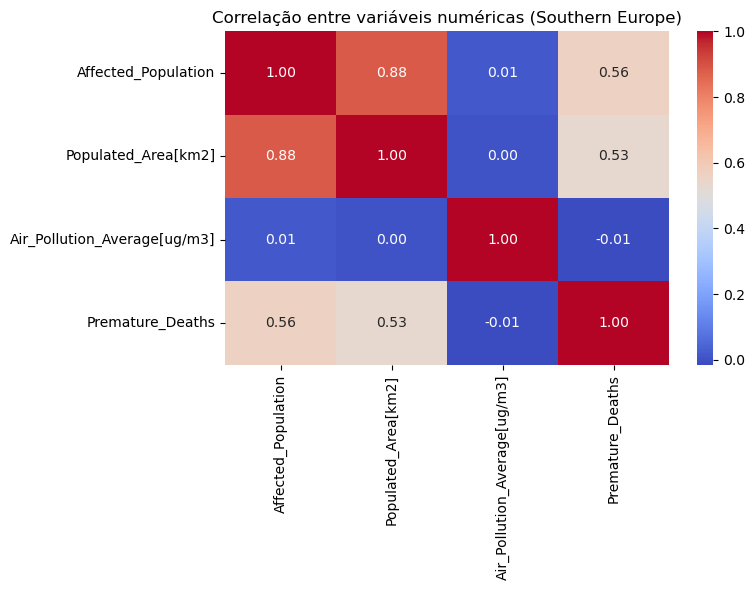

In [22]:
# Filtrar apenas os dados da Europa do Sul
df_south = df[df['Region'] == 'Southern Europe']

# Selecionar apenas as colunas numéricas + 'Premature_Deaths'
# Correlação de Pearson só é aplicável a variáveis numéricas 
cols_corr = ['Affected_Population', 'Populated_Area[km2]', 'Air_Pollution_Average[ug/m3]', 'Premature_Deaths']
df_corr = df_south[cols_corr]

# Calcular matriz de correlação de Pearson
corr_matrix = df_corr.corr()

# Matriz de correlação
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlação entre variáveis numéricas (Southern Europe)')
plt.tight_layout()
plt.show()

> * Entre Affected_Population e Populated_Area existe uma correlação forte e positiva, pois o valor encontra-se perto de 1 (0.88). Ou seja, regiões com maior área populacional tendem a ter uma população mais afetada. 
> 
> * Entre Affected_Population e Premature_Deaths existe uma correlação positiva (0.56), ou seja, quanto maior a população afetada, maior é o número de mortes prematuras. 
> 
> * Entre Populated_Area e Premature_Deaths existe, também uma correlação positiva (0.53), ou seja, regiões com mais população, tendem a ter mais mortes prematuras.
> 
> * Entre Air_Pollution_Average e Premature_Deaths existe uma correlação quase nula e negativa (-0.01), o que leva a concluir que o nível médio de poluição não tem relação direta linear com o número de mortes prematuras.

In [43]:
# Considerar apenas Southern Europe
df_southern = df[df['Region'] == 'Southern Europe']

In [44]:
# ---------------- Definir o KFold (para todos os modelos) ----------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [45]:
# Variàvel alvo global
y = df_southern['Premature_Deaths'].values

# **4.2.2 Modelo de regressão linear simples para prever mortes prematuras**

#### Treino do modelo linear com K-Fold Cross Validation e função linear

In [26]:
# Variável de interesse
X = df_southern[['Affected_Population']].values

model = LinearRegression()

# Inicializa listas para armazenar métricas e parâmetros
mae_scores = []
rmse_scores = []
coefs = []
intercepts = []

# Validação cruzada: divide os dados em k-folds definido antes
for train_index, test_index in kf.split(X):
    # Divide dados em treino e teste com base nos índices fornecidos pelo k-fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Treina o modelo com os dados de treino
    model.fit(X_train, y_train)
    # Faz previsões sobre o conjunto de teste
    y_pred = model.predict(X_test)
    
    # Calcula o Erro Médio Absoluto e a Raiz do Erro Quadrático Médio
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Guarda os erros e os parâmetros da regressão para análise posterior
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    coefs.append(model.coef_[0])
    intercepts.append(model.intercept_)

# Exibe a equação da regressão após todas as iterações da validação cruzada
print("a) Função linear média resultante:")
print(f"y = {np.mean(coefs):.6f} * X + {np.mean(intercepts):.4f}")

a) Função linear média resultante:
y = 0.000383 * X + -13.8409


Em cada iteração, o modelo foi treinado em parte dos dados e testado no subconjunto restante. Em cada fold, foram registados os coeficientes da regressão, o MAE e a RMSE.

A função linear indica que, segundo o modelo, para cada aumento de 1.000.000 na população afetada, o número previsto de mortes prematuras aumenta aproximadamente em 383.

#### Visualização: reta da regressão + diagrama de dispersão

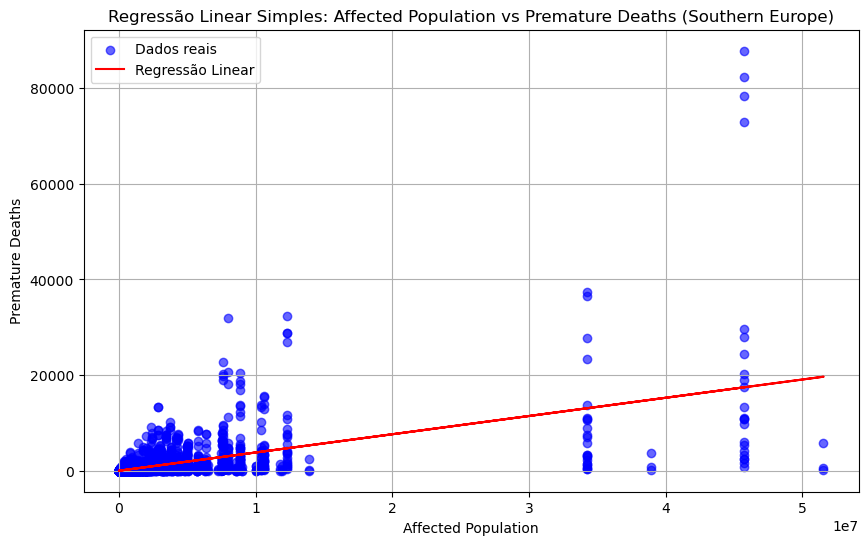

In [27]:
# Ajusta o conjunto total para visualização
model.fit(X, y)
y_pred_all = model.predict(X)

plt.figure(figsize=(10,6))
plt.scatter(X, y, color='blue', label='Dados reais', alpha=0.6)
plt.plot(X, y_pred_all, color='red', label='Regressão Linear')
plt.xlabel('Affected Population')
plt.ylabel('Premature Deaths')
plt.title('Regressão Linear Simples: Affected Population vs Premature Deaths (Southern Europe)')
plt.legend()
plt.grid(True)
plt.show()

O gráfico apresentado mostra os dados reais (pontos azuis) e a linha da regressão ajustada (linha vermelha). 

Apesar de existir uma tendência crescente, é visível que há dispersão significativa nos dados, com vários outliers.

Ainda assim, o modelo consegue captar uma tendência geral positiva entre o tamanho da população afetada e o número de mortes prematuras, validando parcialmente a hipótese de que regiões mais populosas e afetadas tendem a ter um impacto maior na saúde pública.

#### Cálculo final de MAE e RMSE médios (validação cruzada)

In [28]:
print("c) Erro Médio Absoluto (MAE): {:.2f}".format(np.mean(mae_scores)))
print("   Raiz do Erro Quadrático Médio (RMSE): {:.2f}".format(np.mean(rmse_scores)))

c) Erro Médio Absoluto (MAE): 432.29
   Raiz do Erro Quadrático Médio (RMSE): 1972.63


Sobre o desempenho do modelo conclui-se que:
- Em média, o modelo erra por cerca de 432 mortes prematuras;
- Considerando que o RMSE penaliza mais fortemente grandes erros, este valor indica que existem alguns casos com desvios significativos.

# **4.2.3 Desenvolver modelos para prever mortes prematuras**

**[NOTA]** : O ficheiro 'models_training.py' implementa o treino e avaliação de modelos de regressão com validação cruzada e tuning opcional por GridSearch.

#### Cálculo dos VIF

In [29]:
# remover a coluna alvo
X_corr = df_corr.drop(columns=['Premature_Deaths'])

vif_data = pd.DataFrame()
vif_data['feature'] = X_corr.columns
vif_data['VIF'] = [variance_inflation_factor(X_corr.values, i) for i in range(X_corr.shape[1])]

print("\n--- VIF ---")
print(vif_data)


--- VIF ---
                        feature       VIF
0           Affected_Population  5.087119
1           Populated_Area[km2]  5.072638
2  Air_Pollution_Average[ug/m3]  1.034444


#### Seleção de variáveis independentes a usar

- Remover a variável alvo.
- Remover a coluna Air_Pollution_Average[ug/m3] pela correlação quase nula com o alvo.
- Remover 'Populated_Area[km2]' por ser uma feature redundante (verificar os VIFs).

In [46]:
X = df_southern.drop(columns=['Premature_Deaths', 'Air_Pollution_Average[ug/m3]', 'Populated_Area[km2]', 'Region'])

# Atualizar numeric_cols para não incluir as colunas removidas
numeric_cols = [col for col in numeric_cols if col in X.columns]

In [41]:
# ---------------- Preparação dos preprocessadores ----------------
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),    # Normalização das variáveis numéricas
        ('cat', OneHotEncoder(), categorical_cols)  # Codificação one-hot das variáveis categóricas
    ]
)

preprocessor_tree = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False), categorical_cols)
    ],
    remainder='passthrough' # Manter as colunas numéricas sem transformação para o modelo de árvore de decisão
)

## a) Regressão linear múltipla.

#### Treino do modelo

In [32]:
# ---------------- Regressão Linear Múltipla ----------------
print("\n--- Regressão Linear Múltipla ---")
rmse_scores, mae_scores, r2_scores, pipeline_lr = train_linear_regression(X, y, preprocessor, kf)

print("\n--- Resultados Médios ---")
print(f"RMSE médio : {np.mean(rmse_scores):.2f}")
print(f"MAE médio : {np.mean(mae_scores):.2f}")
print(f"R² médio  : {np.mean(r2_scores):.2f}")


--- Regressão Linear Múltipla ---

--- Resultados Médios ---
RMSE médio : 1968.97
MAE médio : 523.00
R² médio  : 0.26


#### Visualização dos resultados previstos vs os reais

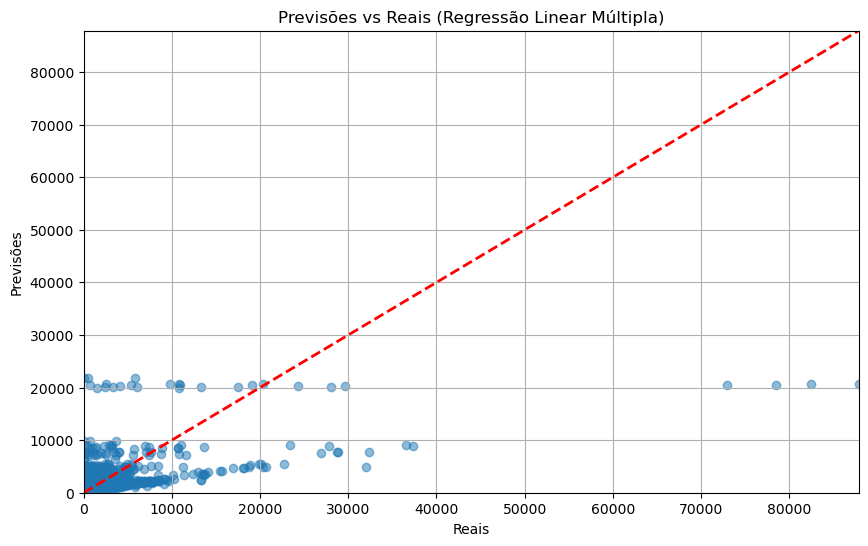

In [33]:
# Gráfico de Previsões vs Reais
pipeline_lr.fit(X, y)
plt.figure(figsize=(10, 6))
plt.scatter(y, pipeline_lr.predict(X), alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.title('Previsões vs Reais (Regressão Linear Múltipla)')
plt.xlabel('Reais')
plt.ylabel('Previsões')
plt.xlim(y.min(), y.max())
plt.ylim(y.min(), y.max())
plt.grid()
plt.show()

## b) Árvore de regressão com otimização dos parâmetros do modelo

#### Teste dos modelos sem utilização da otimização de parâmetros
A flag `False` indica que não estamos a usar o GridSearchCV mas passamos os parametros através da mesma estrutura

>train_regression_tree(X, y, preprocessor_tree, kf, **False**, param_grid_tree)

In [47]:
# ---------------- Testes para Árvore de Regressão ----------------
print("\n--- Árvore de Decisão ---")

# Modelo 1: Árvore livre (sem limite de profundidade)
param_grid_tree = {
    'regressor__max_depth': [None],
    'regressor__min_samples_split': [10],
    'regressor__min_samples_leaf': [5]
}
rmse_scores, mae_scores, r2_scores, best_tree, best_params_tree = train_regression_tree(X, y, preprocessor_tree, kf, False, param_grid_tree)
print("\nMelhores parâmetros encontrados:", best_params_tree)
print("\n--- Resultados Médios ---")
print(f"RMSE médio : {np.mean(rmse_scores):.2f}")
print(f"MAE médio : {np.mean(mae_scores):.2f}")
print(f"R² médio  : {np.mean(r2_scores):.2f}")

# Modelo 2: Árvore moderada (profundidade até 10)
param_grid_tree = {
    'regressor__max_depth': [10],
    'regressor__min_samples_split': [5],
    'regressor__min_samples_leaf': [3]
}
rmse_scores, mae_scores, r2_scores, best_tree, best_params_tree = train_regression_tree(X, y, preprocessor_tree, kf, False, param_grid_tree)
print("\nMelhores parâmetros encontrados:", best_params_tree)
print("\n--- Resultados Médios ---")
print(f"RMSE médio : {np.mean(rmse_scores):.2f}")
print(f"MAE médio : {np.mean(mae_scores):.2f}")
print(f"R² médio  : {np.mean(r2_scores):.2f}")

# Modelo 3: Árvore controlada (profundidade mais baixa); evitar sobreajuste
param_grid_tree = {
    'regressor__max_depth': [5],
    'regressor__min_samples_split': [5],
    'regressor__min_samples_leaf': [2]
}
rmse_scores, mae_scores, r2_scores, best_tree, best_params_tree = train_regression_tree(X, y, preprocessor_tree, kf, False, param_grid_tree)
print("\nMelhores parâmetros encontrados:", best_params_tree)
print("\n--- Resultados Médios ---")
print(f"RMSE médio : {np.mean(rmse_scores):.2f}")
print(f"MAE médio : {np.mean(mae_scores):.2f}")
print(f"R² médio  : {np.mean(r2_scores):.2f}")


--- Árvore de Decisão ---

Melhores parâmetros encontrados: {'regressor__max_depth': None, 'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 5}

--- Resultados Médios ---
RMSE médio : 1900.97
MAE médio : 429.53
R² médio  : 0.30

Melhores parâmetros encontrados: {'regressor__max_depth': 10, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 3}

--- Resultados Médios ---
RMSE médio : 1953.14
MAE médio : 421.84
R² médio  : 0.26

Melhores parâmetros encontrados: {'regressor__max_depth': 5, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 2}

--- Resultados Médios ---
RMSE médio : 2108.68
MAE médio : 417.18
R² médio  : 0.17


>No caso das árvores de decisão, observou-se que o aumento da profundidade do modelo levou inicialmente a uma melhoria do desempenho, mas também a um aumento da variância, o que evidencia sintomas de overfitting.

#### Treino do modelo com otimização dos parâmetros

In [48]:
print("\n--- Árvore de Decisão ---")
param_grid_tree = {
    'regressor__max_depth': [3, 5, 10, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}
rmse_scores, mae_scores, r2_scores, best_tree, best_params_tree = train_regression_tree(X, y, preprocessor_tree, kf, True, param_grid_tree)
print("\nMelhores parâmetros encontrados:", best_params_tree)
print("\n--- Resultados Médios ---")
print(f"RMSE médio : {np.mean(rmse_scores):.2f}")
print(f"MAE médio : {np.mean(mae_scores):.2f}")
print(f"R² médio  : {np.mean(r2_scores):.2f}")


--- Árvore de Decisão ---

Melhores parâmetros encontrados: {'regressor__max_depth': 5, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 2}

--- Resultados Médios ---
RMSE médio : 1848.74
MAE médio : 401.40
R² médio  : 0.34


#### Visualização: Árvore de Regressão

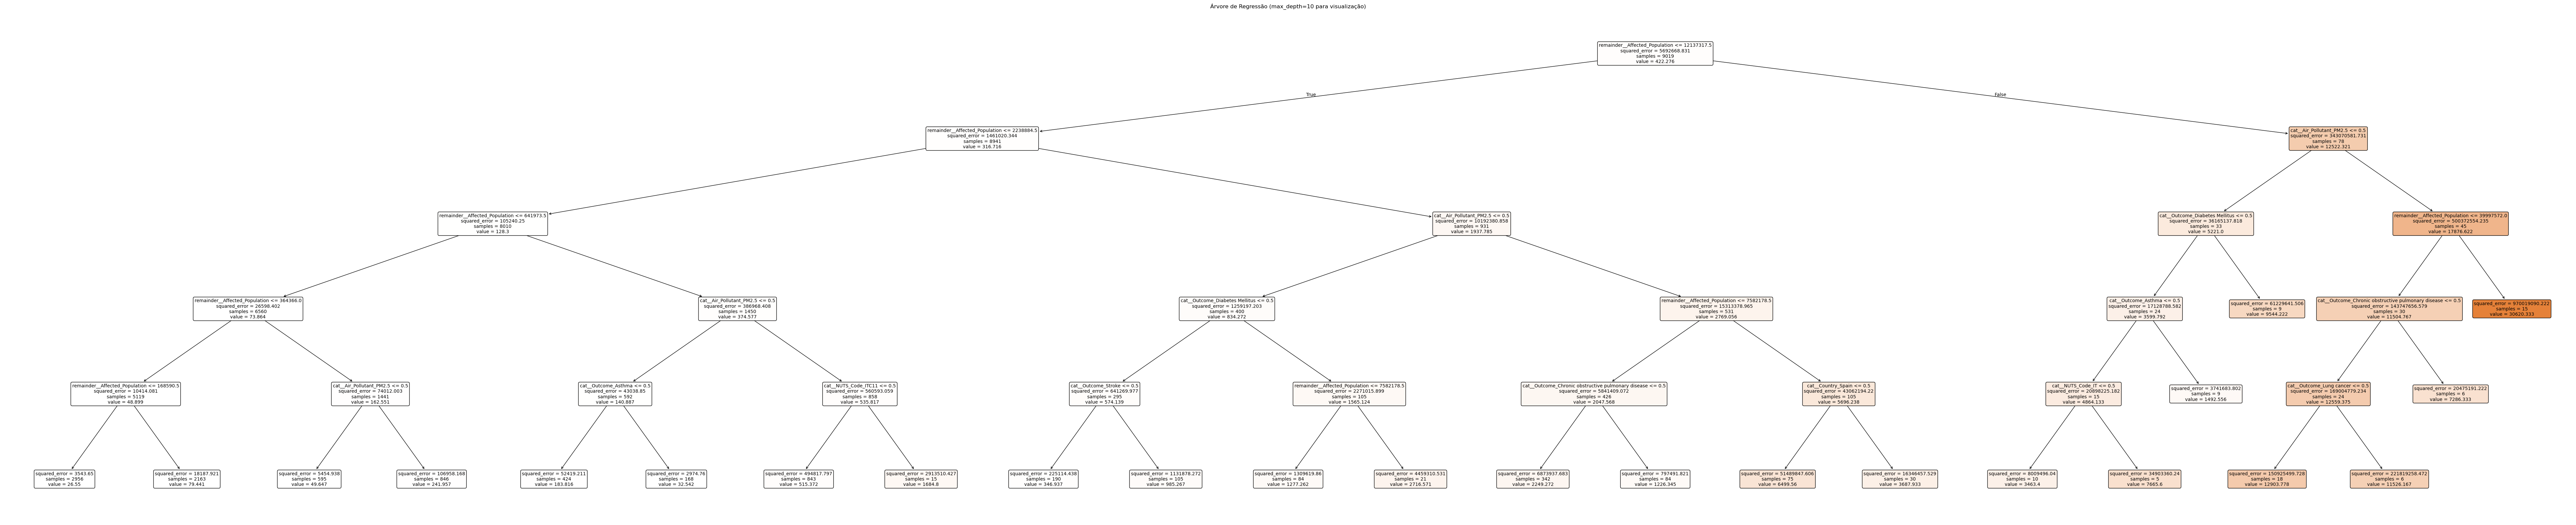

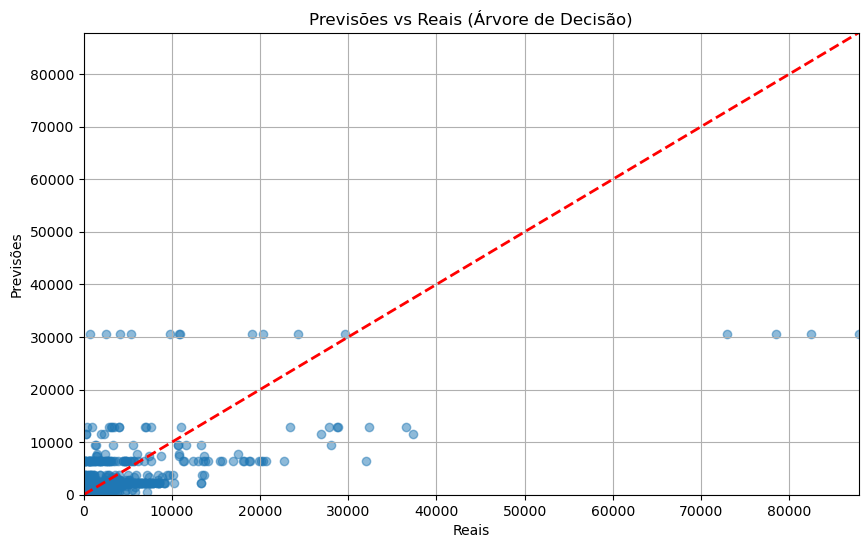

In [55]:
best_tree.fit(X, y)
preprocessor_fitted = best_tree.named_steps['preprocessor']
feature_names = preprocessor_fitted.get_feature_names_out()
plt.figure(figsize=(100, 20))
plot_tree(
    best_tree.named_steps['regressor'],
    feature_names=feature_names,
    filled=True,
    rounded=True,
    max_depth=10,
    fontsize=10
)
plt.title("Árvore de Regressão (max_depth=10 para visualização)")
plt.show()

# Gráfico de Previsões vs Reais
plt.figure(figsize=(10, 6))
plt.scatter(y, best_tree.predict(X), alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.title('Previsões vs Reais (Árvore de Decisão)')
plt.xlabel('Reais')
plt.ylabel('Previsões')
plt.xlim(y.min(), y.max())
plt.ylim(y.min(), y.max())
plt.grid()
plt.show()

## c) SVM com otimização do kernel

#### Teste dos modelos sem utilização da otimização de parâmetros
A flag `False` indica que não estamos a usar o GridSearchCV mas passamos os parametros através da mesma estrutura

>train_svm(X, y, preprocessor_tree, kf, **False**, param_grid_tree)

In [36]:
print("\n--- SVM ---")

# Modelo 1: SVM com kernel linear (baseline simples)
param_grid_svm = {
    'regressor__kernel': ['linear'],
    'regressor__C': [1],
    'regressor__gamma': ['scale']
}
mae_svm, rmse_svm, r2_svm, best_svm, best_params_svm = train_svm(X, y, preprocessor, kf, False, param_grid_svm)
print("\nParâmetros do SVM:")
print(best_params_svm)
print("\n--- Resultados Médios ---")
print(f"{'MAE':<10}: {np.mean(mae_svm):.2f}")
print(f"{'RMSE':<10}: {np.mean(rmse_svm):.2f}")
print(f"{'R2':<10}: {np.mean(r2_svm):.2f}")

# Modelo 2: SVM com kernel rbf (mais flexível, recomendado para dados não-lineares)
param_grid_svm = {
    'regressor__kernel': ['rbf'],
    'regressor__C': [10],
    'regressor__gamma': ['scale']
}
mae_svm, rmse_svm, r2_svm, best_svm, best_params_svm = train_svm(X, y, preprocessor, kf, False, param_grid_svm)
print("\nParâmetros do SVM:")
print(best_params_svm)
print("\n--- Resultados Médios ---")
print(f"{'MAE':<10}: {np.mean(mae_svm):.2f}")
print(f"{'RMSE':<10}: {np.mean(rmse_svm):.2f}")
print(f"{'R2':<10}: {np.mean(r2_svm):.2f}")

# Modelo 3: SVM com kernel poly de grau 2 (para testar interações quadráticas)
param_grid_svm = {
    'regressor__kernel': ['poly'],
    'regressor__C': [10],
    'regressor__gamma': ['scale'],
    'regressor__degree': [2]
}
mae_svm, rmse_svm, r2_svm, best_svm, best_params_svm = train_svm(X, y, preprocessor, kf, False, param_grid_svm)
print("\nParâmetros do SVM:")
print(best_params_svm)
print("\n--- Resultados Médios ---")
print(f"{'MAE':<10}: {np.mean(mae_svm):.2f}")
print(f"{'RMSE':<10}: {np.mean(rmse_svm):.2f}")
print(f"{'R2':<10}: {np.mean(r2_svm):.2f}")

# Modelo 4: SVM com kernel poly de grau 3 (mais complexo, mas pode sobreajustar)
param_grid_svm = {
    'regressor__kernel': ['poly'],
    'regressor__C': [10],
    'regressor__gamma': ['scale'],
    'regressor__degree': [3]
}
mae_svm, rmse_svm, r2_svm, best_svm, best_params_svm = train_svm(X, y, preprocessor, kf, False, param_grid_svm)
print("\nParâmetros do SVM:")
print(best_params_svm)
print("\n--- Resultados Médios ---")
print(f"{'MAE':<10}: {np.mean(mae_svm):.2f}")
print(f"{'RMSE':<10}: {np.mean(rmse_svm):.2f}")
print(f"{'R2':<10}: {np.mean(r2_svm):.2f}")


--- SVM ---

Parâmetros do SVM:
{'regressor__kernel': 'linear', 'regressor__C': 1, 'regressor__gamma': 'scale', 'regressor__degree': 3}

--- Resultados Médios ---
MAE       : 360.99
RMSE      : 2170.18
R2        : 0.14

Parâmetros do SVM:
{'regressor__kernel': 'rbf', 'regressor__C': 10, 'regressor__gamma': 'scale', 'regressor__degree': 3}

--- Resultados Médios ---
MAE       : 368.87
RMSE      : 2296.42
R2        : 0.03

Parâmetros do SVM:
{'regressor__kernel': 'poly', 'regressor__C': 10, 'regressor__gamma': 'scale', 'regressor__degree': 2}

--- Resultados Médios ---
MAE       : 348.57
RMSE      : 2043.04
R2        : 0.23

Parâmetros do SVM:
{'regressor__kernel': 'poly', 'regressor__C': 10, 'regressor__gamma': 'scale', 'regressor__degree': 3}

--- Resultados Médios ---
MAE       : 351.16
RMSE      : 2033.43
R2        : 0.23


>O modelo SVR com kernel poly de grau 3 e C=10 destacou-se com os melhores resultados globais em termos de MAE e R², superando tanto o rbf como o linear. Este resultado sublinha a importância de testar diferentes funções kernel em problemas não lineares.

#### Treino do modelo

In [37]:
print("\n--- SVM ---")
param_grid_svm = {
    'regressor__kernel': ['linear', 'rbf', 'poly'],
    'regressor__C': [0.1, 1, 10, 100],
    'regressor__gamma': ['scale', 'auto'],
    'regressor__degree': [2, 3, 4]
}
mae_svm, rmse_svm, r2_svm, best_svm, best_params_svm = train_svm(X, y, preprocessor, kf, True, param_grid_svm)
print("\nMelhores parâmetros do SVM:")
print(best_params_svm)
print("\n--- Resultados Médios ---")
print(f"{'MAE':<10}: {np.mean(mae_svm):.2f}")
print(f"{'RMSE':<10}: {np.mean(rmse_svm):.2f}")
print(f"{'R2':<10}: {np.mean(r2_svm):.2f}")


--- SVM ---

Melhores parâmetros do SVM:
{'regressor__C': 100, 'regressor__degree': 2, 'regressor__gamma': 'scale', 'regressor__kernel': 'poly'}

--- Resultados Médios ---
MAE       : 332.24
RMSE      : 1974.55
R2        : 0.28


#### Visualização dos resultados previstos vs os reais

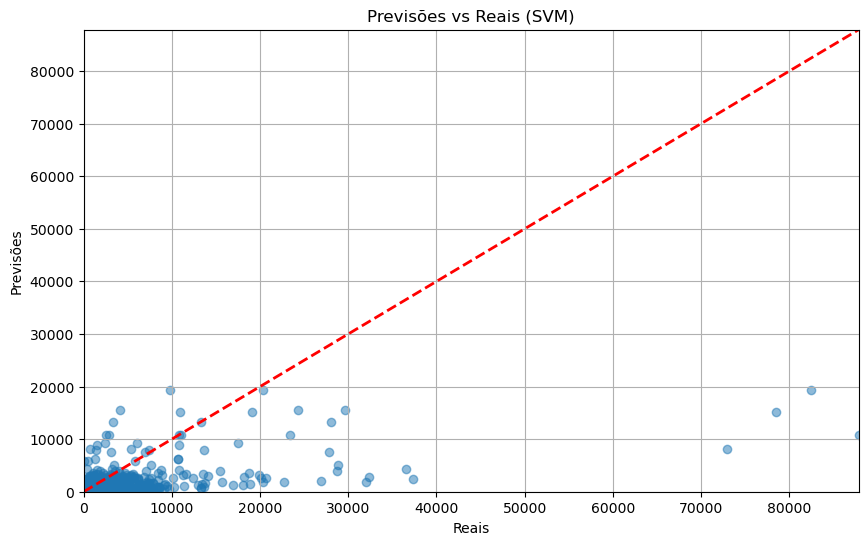

In [56]:
# Gráfico de Previsões vs Reais
best_svm.fit(X, y)
plt.figure(figsize=(10, 6))
plt.scatter(y, best_svm.predict(X), alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.title('Previsões vs Reais (SVM)')
plt.xlabel('Reais')
plt.ylabel('Previsões')
plt.xlim(y.min(), y.max())
plt.ylim(y.min(), y.max())
plt.grid()
plt.show()

## d) Rede neuronal com otimização da configuração da rede

#### Teste dos modelos sem utilização da otimização de parâmetros
A flag `False` indica que não estamos a usar o GridSearchCV mas passamos os parametros através da mesma estrutura

>train_mlp(X, y, preprocessor_tree, kf, **False**, param_grid_tree)

In [38]:
print("\n--- Rede Neuronal ---")

# Modelo 1: configuração pequena, solver eficiente para datasets pequenos
param_grid_mlp = {
    'regressor__hidden_layer_sizes': [(10,)],
    'regressor__activation': ['relu'],
    'regressor__solver': ['lbfgs'],  # convergência rápida, sem taxa de aprendizagem
}
mae_mlp, rmse_mlp, r2_mlp, best_mlp, best_params_mlp = train_mlp(X, y, preprocessor, kf, False, param_grid_mlp)
print("\nParâmetros do MLPRegressor:")
print(best_params_mlp)
print("\n--- Resultados Médios ---")
print(f"MAE: {np.mean(mae_mlp):.2f}")
print(f"RMSE: {np.mean(rmse_mlp):.2f}")
print(f"R²: {np.mean(r2_mlp):.3f}")

# Modelo 2: rede ligeiramente maior, adam com relu (configuração robusta)
param_grid_mlp = {
    'regressor__hidden_layer_sizes': [(20,)],
    'regressor__activation': ['relu'],
    'regressor__solver': ['adam'],
    'regressor__learning_rate_init': [0.001]
}
mae_mlp, rmse_mlp, r2_mlp, best_mlp, best_params_mlp = train_mlp(X, y, preprocessor, kf, False, param_grid_mlp)
print("\nParâmetros do MLPRegressor:")
print(best_params_mlp)
print("\n--- Resultados Médios ---")
print(f"MAE: {np.mean(mae_mlp):.2f}")
print(f"RMSE: {np.mean(rmse_mlp):.2f}")
print(f"R²: {np.mean(r2_mlp):.3f}")

# Modelo 3: mais tradicional com tanh e sgd, para ver o desempenho em redes pequenas
param_grid_mlp = {
    'regressor__hidden_layer_sizes': [(10,)],
    'regressor__activation': ['tanh'],
    'regressor__solver': ['sgd'],
    'regressor__learning_rate_init': [0.01]
}
mae_mlp, rmse_mlp, r2_mlp, best_mlp, best_params_mlp = train_mlp(X, y, preprocessor, kf, False, param_grid_mlp)
print("\nParâmetros do MLPRegressor:")
print(best_params_mlp)
print("\n--- Resultados Médios ---")
print(f"MAE: {np.mean(mae_mlp):.2f}")
print(f"RMSE: {np.mean(rmse_mlp):.2f}")
print(f"R²: {np.mean(r2_mlp):.3f}")

# Modelo 4: 2 camadas escondidas com adam e relu
param_grid_mlp = {
    'regressor__hidden_layer_sizes': [(15, 5)],
    'regressor__activation': ['relu'],
    'regressor__solver': ['adam'],
    'regressor__learning_rate_init': [0.001]
}
mae_mlp, rmse_mlp, r2_mlp, best_mlp, best_params_mlp = train_mlp(X, y, preprocessor, kf, False, param_grid_mlp)
print("\nParâmetros do MLPRegressor:")
print(best_params_mlp)
print("\n--- Resultados Médios ---")
print(f"MAE: {np.mean(mae_mlp):.2f}")
print(f"RMSE: {np.mean(rmse_mlp):.2f}")
print(f"R²: {np.mean(r2_mlp):.3f}")


--- Rede Neuronal ---

Parâmetros do MLPRegressor:
{'regressor__hidden_layer_sizes': (10,), 'regressor__activation': 'relu', 'regressor__solver': 'lbfgs', 'regressor__learning_rate_init': 0.001}

--- Resultados Médios ---
MAE: 461.53
RMSE: 2226.89
R²: 0.073

Parâmetros do MLPRegressor:
{'regressor__hidden_layer_sizes': (20,), 'regressor__activation': 'relu', 'regressor__solver': 'adam', 'regressor__learning_rate_init': 0.001}

--- Resultados Médios ---
MAE: 416.73
RMSE: 1855.93
R²: 0.352

Parâmetros do MLPRegressor:
{'regressor__hidden_layer_sizes': (10,), 'regressor__activation': 'tanh', 'regressor__solver': 'sgd', 'regressor__learning_rate_init': 0.01}

--- Resultados Médios ---
MAE: 548.49
RMSE: 2122.92
R²: 0.128

Parâmetros do MLPRegressor:
{'regressor__hidden_layer_sizes': (15, 5), 'regressor__activation': 'relu', 'regressor__solver': 'adam', 'regressor__learning_rate_init': 0.001}

--- Resultados Médios ---
MAE: 417.43
RMSE: 1874.74
R²: 0.335


>Verifica-se que o desempenho foi altamente dependente do solver, da função de ativação e da estrutura da rede. O solver adam, em combinação com a função de ativação relu e arquiteturas com múltiplas camadas ocultas, revelou-se o mais eficaz, contrastando com lbfgs e sgd, que apresentaram desempenhos inferiores.

#### Treino do modelo com otimização de parâmetros

In [39]:
print("\n--- Rede Neuronal ---")
param_grid_mlp = {
    'regressor__hidden_layer_sizes': [(3,), (7,), (10,), (7, 3), (10, 5)],
    'regressor__activation': ['relu', 'tanh'],
    'regressor__solver': ['sgd', 'lbfgs'],
    'regressor__learning_rate_init': [0.001, 0.01]
}
mae_mlp, rmse_mlp, r2_mlp, best_mlp, best_params_mlp = train_mlp(X, y, preprocessor, kf, True, param_grid_mlp)
print("\nMelhores parâmetros do MLPRegressor:")
print(best_params_mlp)
print("\n--- Resultados Médios ---")
print(f"MAE: {np.mean(mae_mlp):.2f}")
print(f"RMSE: {np.mean(rmse_mlp):.2f}")
print(f"R²: {np.mean(r2_mlp):.3f}")


--- Rede Neuronal ---

Melhores parâmetros do MLPRegressor:
{'regressor__activation': 'relu', 'regressor__hidden_layer_sizes': (3,), 'regressor__learning_rate_init': 0.001, 'regressor__solver': 'lbfgs'}

--- Resultados Médios ---
MAE: 468.99
RMSE: 1871.05
R²: 0.322


#### Visualização dos resultados previstos vs os reais

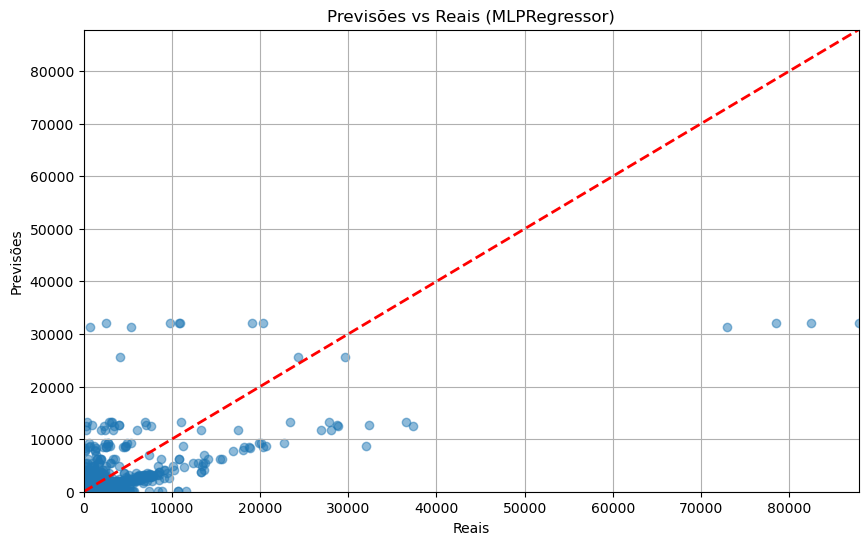

In [57]:
# Gráfico de Previsões vs Reais
best_mlp.fit(X, y)
plt.figure(figsize=(10, 6))
plt.scatter(y, best_mlp.predict(X), alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.title('Previsões vs Reais (MLPRegressor)')
plt.xlabel('Reais')
plt.ylabel('Previsões')
plt.xlim(y.min(), y.max())
plt.ylim(y.min(), y.max())
plt.grid()
plt.show()

#### Curva de aprendizagem (se possível)

In [58]:
# Plot loss curve only if solver supports it
if best_params_mlp['regressor__solver'] in ['sgd', 'adam']:
    plt.figure(figsize=(8, 5))
    plt.plot(best_mlp.named_steps['regressor'].loss_curve_)
    plt.title('MLPRegressor Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.show()
else:
    print("Loss curve is not available for solver 'lbfgs'.")

Loss curve is not available for solver 'lbfgs'.


# **Comparação de Resultados**
**[NOTA]** : Os resultados do MAE, MRSE e R2 das alíneas 4.2.3 estão em *'resultados_regressao/'*
| Modelo                    | MAE    | RMSE    | R2   |
| ------------------------- | ------ | ------- | ---- |
| Regressão Linear Múltipla | 523.00 | 1968.97 | 0.26 |
| Árvore de Decisão         | 401.40 | ***1848.74*** | ***0.34*** |
| SVM                       | ***338.27*** | 1974.30 | 0.28 |
| Rede Neural               | 469.81 | 1974.66 | 0.28 |

> Tendo em conta os valores apresentados na tabela acima, o SVM apresenta o menor valor de erro médio absoluto e a Árvore de Decisão o menor valor para a raiz do erro médio quadrático. Quanto ao valor da proporção da variância explicada pelos modelos, a Árvore de Decisão apresenta o valor mais alto e, por fim, a Regressão Linear Múltipla apresenta o pior desempenho a nível global. Assim sendo, **os dois melhores modelos são a Árvore de Decisão e o SVM**.

# **Teste t-student para dois melhores modelos**
##### Para testar se a diferença é significativa, utilizámos o teste t-sudent com as estimativas do MAE como métrica principal de desempenho (mais estável, robusta e interpretável)

##### As hipóteses que testámos foram as seguintes:
- H₀ (hipótese nula): a média dos MAEs dos dois modelos é igual.
- H₁ (alternativa): há uma diferença significativa entre os MAEs.

In [59]:
# Valores extraídos dos ficheiros de resultados
svm_mae = [324.6845, 356.8997, 333.2855, 318.4403, 358.0162]
rt_mae = [387.7154, 409.3296, 402.9762, 396.4452, 410.5294]

t_stat, p_value = ttest_rel(rt_mae, svm_mae)
print(f"t = {t_stat:.3f}, p = {p_value:.4f}")

t = 12.735, p = 0.0002


> Com um valor-p de 0.0002, e assumindo um nível de significância de 5%, rejeita-se a hipótese nula. Concluímos que a diferença entre os modelos SVM e Árvore de Regressão é estatisticamente significativa, com a SVM apresentando um desempenho superior em termos de erro médio absoluto (MAE).

> Assim, enquanto o SVM se destaca pela sua precisão preditiva, a Árvore de Decisão tem uma solução mais interpretável. No entanto, neste trabalho, optou-se por privilegiar o desempenho preditivo em detrimento da interpretabilidade, sendo o SVM considerado a melhor escolha.